In [1]:
import numpy as np
import pandas as pd 

import os

input_dir = '/kaggle/input/playground-series-s5e9'


In [2]:
# Ingest
from sklearn.preprocessing import StandardScaler

def ingest_data(input_dir):
    train_csv = pd.read_csv(os.path.join(input_dir, 'train.csv'))
    test_csv = pd.read_csv(os.path.join(input_dir, 'test.csv'))

    print(train_csv.describe())

    ground_truth = 'BeatsPerMinute'

    X_train_df = train_csv.drop(columns=['id', ground_truth])
    X_test_df = test_csv.drop(columns=['id'])

    num_cols = X_train_df.select_dtypes(exclude='object').columns

    scaler = StandardScaler()

    # print("Train NA per col:\n", train_csv.isna().sum())
    # print("Test NA per col:\n",  test_csv.isna().sum())

  
    y_train = train_csv[ground_truth].astype('float32')

    X_train = scaler.fit_transform(X_train_df[num_cols]).astype('float32')
    X_test = scaler.transform(X_test_df[num_cols]).astype('float32')

    # std = X_train.std(numeric_only=True)
    # print("Zero-variance columns:", list(std[std == 0].index))

    assert np.isfinite(X_train).all(), "X_train has NaN/Inf"
    assert np.isfinite(X_test).all(),  "X_test has NaN/Inf"
    assert np.isfinite(y_train.to_numpy()).all(), "y has NaN/Inf"

    return X_train, y_train, X_test

X_train, y_train, X_test = ingest_data(input_dir=input_dir)

print(X_train.shape, y_train.shape, X_test.shape)

                  id    RhythmScore  AudioLoudness   VocalContent  \
count  524164.000000  524164.000000  524164.000000  524164.000000   
mean   262081.500000       0.632843      -8.379014       0.074443   
std    151313.257586       0.156899       4.616221       0.049939   
min         0.000000       0.076900     -27.509725       0.023500   
25%    131040.750000       0.515850     -11.551933       0.023500   
50%    262081.500000       0.634686      -8.252499       0.066425   
75%    393122.250000       0.739179      -4.912298       0.107343   
max    524163.000000       0.975000      -1.357000       0.256401   

       AcousticQuality  InstrumentalScore  LivePerformanceLikelihood  \
count    524164.000000      524164.000000              524164.000000   
mean          0.262913           0.117690                   0.178398   
std           0.223120           0.131845                   0.118186   
min           0.000005           0.000001                   0.024300   
25%           0.06

In [3]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# y_train = y_train.to_numpy().astype('float32', copy=False)
# y_test  = y_test.to_numpy().astype('float32', copy=False)

X_train = torch.from_numpy(X_train_df.astype('float32', copy=False))
X_val = torch.from_numpy(X_val_df.astype('float32', copy=False))
y_train = torch.from_numpy(y_train_df.values).unsqueeze(1)
y_val = torch.from_numpy(y_val_df.values).unsqueeze(1)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


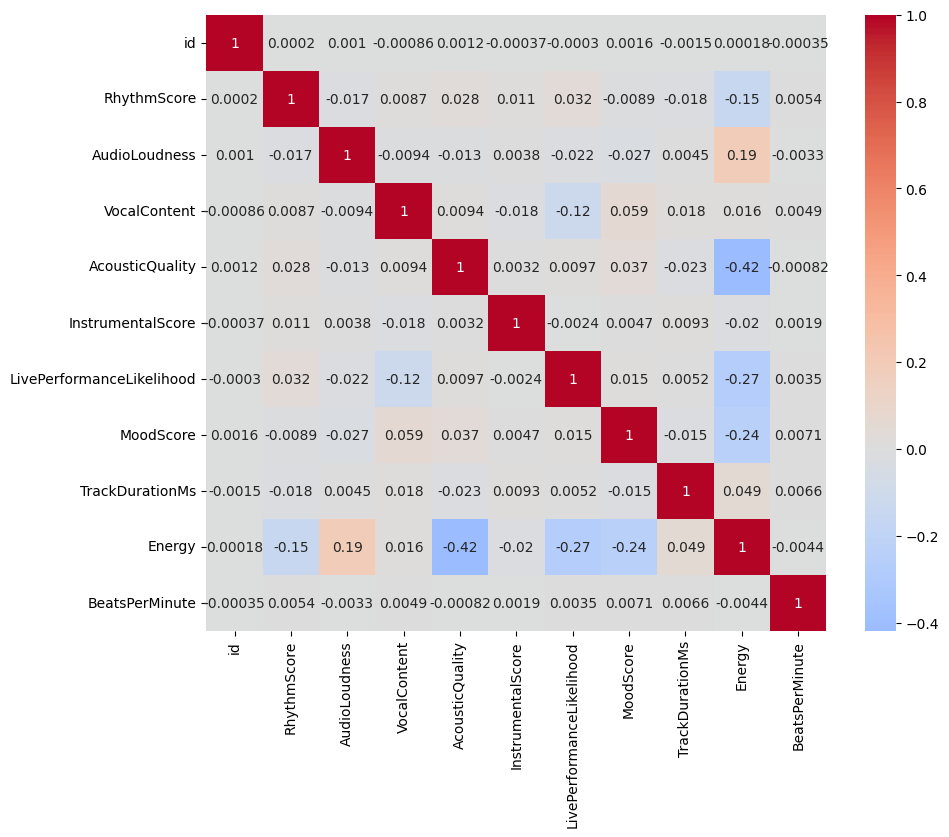

In [4]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

train_csv = pd.read_csv(os.path.join(input_dir, 'train.csv'))
# sns.scatterplot(data=train_csv, x='AudioLoudness', y='BeatsPerMinute')

plt.figure(figsize=(10, 8))
corr = train_csv.corr(numeric_only=True)  
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)

plt.show()

In [5]:
from torch import nn

class CustomMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

net = CustomMLP()

In [6]:
import torch
def train(net, dataloader, num_epochs, lr, wd, device):
    torch.manual_seed(1)
    net = net.to(device)
    loss = nn.MSELoss()
    optim = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
    for epoch in range(num_epochs):
        net.train()
        running, seen = 0.0, 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            optim.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optim.step()
            running += l.item() * X.size(0)
            seen += X.size(0)
            mse = running / seen
            rmse = mse ** 0.5
        # if (epoch+1) % 5 == 0: 
        # print(f'Epoch {epoch + 1} Loss; {l.item():.4f}')
            
        print(f'Epoch {epoch + 1} RMSE Loss: {rmse:.4f}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
train(net, train_loader, 10, 0.001, 0.0001, device)

Using: cuda
Epoch 1 RMSE Loss: 29.7902
Epoch 2 RMSE Loss: 27.5685
Epoch 3 RMSE Loss: 27.5130
Epoch 4 RMSE Loss: 27.4813
Epoch 5 RMSE Loss: 27.4465
Epoch 6 RMSE Loss: 27.4139
Epoch 7 RMSE Loss: 27.3917
Epoch 8 RMSE Loss: 27.3267
Epoch 9 RMSE Loss: 27.3158
Epoch 10 RMSE Loss: 27.2820


In [7]:
def eval_rmse(net, loader, device):
    net.eval()
    squared_err, total = 0.0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = net(X)
            squared_err += ((pred - y) ** 2).sum().item()
            total += X.size(0)
    mse = squared_err / total
    return mse ** 0.5

eval_rmse = eval_rmse(net, val_loader, device)
print(f"Eval RMSE: {eval_rmse:.2f}")


Eval RMSE: 26.78


In [10]:
X_test_tensor = torch.from_numpy(X_test.astype('float32')).to(device)
net.eval()

with torch.no_grad():
    preds = net(X_test_tensor).squeeze(1).cpu().numpy()

ids = pd.read_csv(os.path.join(input_dir, 'test.csv'))['id']

submission = pd.DataFrame({
    'id': ids,
    'BeatsPerMinute': preds
})
submission.to_csv('submission.csv', index=False)